In [2]:
%matplotlib inline

# Universal adversarial training

An implementation of the universal adversarial training as proposed in [Universal adversarial training](https://arxiv.org/pdf/1811.11304.pdf) by Shafahi et al. 

Author(s): [Martin Benning](mailto:m.benning@qmul.ac.uk), [Alex Wendland](mailto:a.p.wendland@gmail.com)

Date: 15.05.2019

Last modified: 15.05.2019

## Problem description

In the following code we want to train image identifiers to defend against pertubation attacks, such as FGSM and universal adversarial attacks. Then test their proformances against such attacks.

In [1]:
# Import packages.

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Defining a neural network architecture

There are two types of networks here:

 - Image classifier, and
 - Pertubation generator.
 
Net (Image Classifier)

Input: 28 x 28 byte black and white image (1 channel).
Output: 10 dimensional probability vector.

Layers:
Convolusion layer 5x5 grid outputting 10 channels.
Convolusion layer 5x5 grid outputting 20 channels.
Rectified linear unit layer 320 to 50
Soft max linear layer 50 to 10

Net_Attack (Pertubation generator)

Input: 28 x 28 byte black and white image (1 channel).
Output: 28 x 28 byte pertubation (max value = epsilon).

Layers:
Rectified linear unit layer 784 to 784
Rectified linear unit layer 784 to 784
Linear layer 784 to 784
Clamp values between 0 and epsilon (= 3 unless specified)

In [2]:
# LeNet Model definition

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Attacking Model definition
    
class Net_Attack(nn.Module):
    def __init__(self,epsilon = 3):
        super(Net_Attack, self).__init__()
        self.fc1 = nn.Linear(28*28, 28*28)
        self.fc2 = nn.Linear(28*28, 28*28)
        self.fc3 = nn.Linear(28*28, 28*28)
        self.epsilon = epsilon

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = torch.clamp(x,0,self.epsilon)
        x = x.view(-1, 1, 28, 28)
        return x

## MINST Data Set

For the tests we used the [MINST](https://www.nist.gov/node/1298471/emnist-dataset) data set.

The following loads the data set into a trainer and test loader.

The user can change the batch_size of the train_loader to effect how many updates there are in one epoch. However changing the batch_size of the test_loader will break the testing code, it requires to be set to 1. 

In [3]:
# MNIST Test dataset and dataloader declaration

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=600, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

## Documentation models

Use the following code to load the models we used to generate the test data presented in the report, for this we took the following variables:

stepsize     - 0.05

epsilon      - 3

cap          - 1

mom          - 0.8

no_of_epochs - 200

These were choosen after some experimentation, with no scientific reasoning.

If you wish to generate your own model skip this step.

In [4]:
# Use to load saved networks for the tests ran within the documentation.
# User can edit this to upload their trained models.

model_vani = Net()
model_vani.load_state_dict(torch.load('..\data\model\doc_model_vani_200'))

model_pert = Net()
model_pert.load_state_dict(torch.load('..\data\model\doc_model_pert_200'))

model_def = Net()
model_def.load_state_dict(torch.load('..\data\model\doc_model_def_200'))

model_atk = Net_Attack()
model_atk.load_state_dict(torch.load('..\data\model\doc_model_atk_200'))

## Training new models

The following code will train new models, if you have loaded the models above skip these steps and progress to the testing block.

These models have the following variables.

stepsize     - The learning rate, how far in the direction of the steepist decent we move.

epsilon      - How much the attackers are allowed to peterbe the image.

cap          - The cap for the loss function, see the paper for clarification.

mom          - The momentum within the learning, how much it gets effected by the new change in direction.

no_of_epochs - The number times you run through all the training data.

In [ ]:
# Set variables for training the models.

stepsize = 0.05
epsilon = 3
cap = 1
mom = 0.8
no_of_epochs = 200

In [5]:
# Definition of the capped Mean Squared Error loss function, as defined in the paper.

# Input:  The output of a test of the model, the correct answers to the test and the value to cap each individual test error at.
# Output: The average of the capped errors of the test.

def mse_loss_cap(output, target, cap = 1):
    
    # define the one hot matrix with the answer values being -1
    
    one_hot = torch.zeros(output.size(0),output.size(1))
    for i in range(output.size(0)):
        one_hot[i][int(target[i].item())] = -1
    
    # add output of the model and calculate loss function
    
    loss = torch.add(output, one_hot)
    loss = torch.pow(loss, 2)
    loss = torch.sum(loss, 1)
    loss = torch.clamp(loss,0,cap)
    
    return torch.mean(loss)

# Input:  The output of a test of the model, the correct answers to the test and the value to cap each individual test error at.
# Output: The average of the error values from the test.

def mse_loss_atk(data, target, cap = 1):
    
    # define the one hot matrix with the answer values being -1
    
    one_hot = torch.zeros(output.size(0),output.size(1))
    for i in range(output.size(0)):
        one_hot[i][int(target[i].item())] = -1
    
    # add output of the model and calculate loss function
    
    loss = torch.add(output, one_hot)
    loss = torch.pow(loss, 2)
    loss = torch.sum(loss, 1)
    loss = torch.clamp(loss,0,cap)
    
    # Take one minus values, to turn into minimisation problem.
    
    loss = torch.mul(loss,-1)
    loss = torch.add(torch.ones(loss.size(0)), loss)
    
    return torch.mean(loss)

In [8]:
# Trains a vanila model with no defence against pertubation attacks.

# Initialse the net and the optimiser.

model_vani = Net()
optimiser = optim.SGD(model_vani.parameters(), lr=stepsize, momentum=mom)

# Trains the model for the given number of epochs.

for epoch in range(no_of_epochs):
    
    for data, target in train_loader:
        
        # Runs the model.
        
        output = model_vani(data)
        
        # Calculates the loss function.
        
        loss = mse_loss_cap(output, target,cap)
        
        # Gradient descent for weights.
        
        model_vani.zero_grad()
        loss.backward()
        optimiser.step()
    
    # Informs the user the iteration number every 5 steps.
    
    if (epoch + 1) % 5 == 0:
        print ('Iteration [%d/%d], Loss: %.4f' 
                %(epoch + 1, no_of_epochs, loss.item()))

Iteration [5/200], Loss: 0.1526
Iteration [10/200], Loss: 0.1174
Iteration [15/200], Loss: 0.0843
Iteration [20/200], Loss: 0.0878
Iteration [25/200], Loss: 0.0786
Iteration [30/200], Loss: 0.0641
Iteration [35/200], Loss: 0.0816
Iteration [40/200], Loss: 0.0743
Iteration [45/200], Loss: 0.0662
Iteration [50/200], Loss: 0.0446
Iteration [55/200], Loss: 0.0752
Iteration [60/200], Loss: 0.0457
Iteration [65/200], Loss: 0.0607
Iteration [70/200], Loss: 0.0443
Iteration [75/200], Loss: 0.0625
Iteration [80/200], Loss: 0.0524
Iteration [85/200], Loss: 0.0539
Iteration [90/200], Loss: 0.0581
Iteration [95/200], Loss: 0.0653
Iteration [100/200], Loss: 0.0517
Iteration [105/200], Loss: 0.0399
Iteration [110/200], Loss: 0.0603
Iteration [115/200], Loss: 0.0429
Iteration [120/200], Loss: 0.0630
Iteration [125/200], Loss: 0.0553
Iteration [130/200], Loss: 0.0538
Iteration [135/200], Loss: 0.0651
Iteration [140/200], Loss: 0.0264
Iteration [145/200], Loss: 0.0324
Iteration [150/200], Loss: 0.0531


In [7]:
# Trains a model trained against a universal adversarial attack.

# Initialse the net, universal pertubation, and the optimiser.

model_pert = Net()
pertubation = Variable(torch.zeros(train_loader.dataset.data.size(1), \
                          train_loader.dataset.data.size(2)), requires_grad=True)
optimiser = optim.SGD(model_pert.parameters(), lr=stepsize, momentum=mom)

# Trains the model and pertubation for the given number of epochs.

for epoch in range(no_of_epochs):
    
    for data, target in train_loader:
        
        # Runs the model on the data and the perturbed data.
        
        output_1 = model_pert(data + pertubation.repeat(train_loader.batch_size, 1, 1, 1))
        output_2 = model_pert(data)
        
        # Calculates the loss function on these runs and takes the average.
        # User can change the weighting of the loss function (eg: 7:3 split).
        
        loss_1 = mse_loss_cap(output_1, target, cap)
        loss_2 = mse_loss_cap(output_2, target, cap)
        loss = loss_1 * 0.5 + loss_2 * 0.5
        
        # Gradient descent for weights.
        
        model_pert.zero_grad()
        loss.backward()
        optimiser.step()
        
        # Updates the universal pertubation with a step in the steepest decent and renormalises.
        
        pertubation.data = pertubation.data + stepsize * pertubation.grad
        pertubation.data = pertubation.data / torch.norm(pertubation.data.view(-1, 784)) * epsilon
    
    # Informs the user the iteration number every 5 steps.
    
    if (epoch + 1) % 5 == 0:
        print ('Iteration [%d/%d], Loss: %.4f' 
                %(epoch + 1, no_of_epochs, loss.item()))

Iteration [5/200], Loss: 0.2671
Iteration [10/200], Loss: 0.2068
Iteration [15/200], Loss: 0.1875
Iteration [20/200], Loss: 0.1724
Iteration [25/200], Loss: 0.1580
Iteration [30/200], Loss: 0.1422
Iteration [35/200], Loss: 0.1435
Iteration [40/200], Loss: 0.1731
Iteration [45/200], Loss: 0.1536
Iteration [50/200], Loss: 0.1419
Iteration [55/200], Loss: 0.1319
Iteration [60/200], Loss: 0.1353
Iteration [65/200], Loss: 0.1344
Iteration [70/200], Loss: 0.1561
Iteration [75/200], Loss: 0.1187
Iteration [80/200], Loss: 0.1289
Iteration [85/200], Loss: 0.1493
Iteration [90/200], Loss: 0.1327
Iteration [95/200], Loss: 0.1474
Iteration [100/200], Loss: 0.1598
Iteration [105/200], Loss: 0.1276
Iteration [110/200], Loss: 0.1327
Iteration [115/200], Loss: 0.1574
Iteration [120/200], Loss: 0.1299
Iteration [125/200], Loss: 0.1115
Iteration [130/200], Loss: 0.1315
Iteration [135/200], Loss: 0.1318
Iteration [140/200], Loss: 0.1417
Iteration [145/200], Loss: 0.1338
Iteration [150/200], Loss: 0.1142


In [9]:
# Trains an image classifying and image obsuring net simulataniously.

# Initialse both nets and optimisers.

model_def = Net()
model_atk = Net_Attack(epsilon)
optimiser_def = optim.SGD(model_def.parameters(), lr=stepsize, momentum=mom)
optimiser_atk = optim.SGD(model_atk.parameters(), lr=stepsize, momentum=mom)

# Trains both models for the given number of epochs.

for epoch in range(no_of_epochs):
    
    for data, target in train_loader:
        
        # Runs the defending model on the data and the attacked data.
        
        output_1 = model_def(data + model_atk(data))
        output_2 = model_def(data)
        
        # Calculates the loss function for the defender on these runs and takes the average.
        # User can change the weighting of the loss function (eg: 7:3 split).
        
        loss_1 = mse_loss_cap(output_1, target, cap)
        loss_2 = mse_loss_cap(output_2, target, cap)
        loss = loss_1 * 0.5 + loss_2 * 0.5 
        
        # Gradient descent for defenders weights.
        
        def_loss = loss.item()
        model_def.zero_grad()
        loss.backward()
        optimiser_def.step()
        
        # Runs defending model on attacked data.
        
        output = model_def(data + model_atk(data))
        
        # Calculates the loss function for the attacker.
        
        loss = mse_loss_atk(output, target)
        
        # Gradient descent for defenders weights.
        
        model_atk.zero_grad()
        loss.backward()
        optimiser_atk.step()
    
    # Informs the user the iteration number every 5 steps.
    
    if (epoch + 1) % 5 == 0:
        print ('Iteration [%d/%d], Def Loss: %.4f, Atk Loss: %.4f' 
                %(epoch + 1, no_of_epochs, def_loss, loss.item()))

Iteration [5/200], Def Loss: 0.5504, Atk Loss: 0.2231
Iteration [10/200], Def Loss: 0.5421, Atk Loss: 0.1844
Iteration [15/200], Def Loss: 0.5160, Atk Loss: 0.1862
Iteration [20/200], Def Loss: 0.5272, Atk Loss: 0.1841
Iteration [25/200], Def Loss: 0.4441, Atk Loss: 0.2755
Iteration [30/200], Def Loss: 0.4796, Atk Loss: 0.2795
Iteration [35/200], Def Loss: 0.3109, Atk Loss: 0.5905
Iteration [40/200], Def Loss: 0.2769, Atk Loss: 0.5898
Iteration [45/200], Def Loss: 0.2883, Atk Loss: 0.6067
Iteration [50/200], Def Loss: 0.3295, Atk Loss: 0.5579
Iteration [55/200], Def Loss: 0.4419, Atk Loss: 0.3912
Iteration [60/200], Def Loss: 0.4223, Atk Loss: 0.3935
Iteration [65/200], Def Loss: 0.4654, Atk Loss: 0.2671
Iteration [70/200], Def Loss: 0.4494, Atk Loss: 0.2977
Iteration [75/200], Def Loss: 0.4546, Atk Loss: 0.2855
Iteration [80/200], Def Loss: 0.4883, Atk Loss: 0.2434
Iteration [85/200], Def Loss: 0.5014, Atk Loss: 0.1456
Iteration [90/200], Def Loss: 0.4762, Atk Loss: 0.2271
Iteration [

In [ ]:
# This code will save your trained models.

torch.save(model_vani.state_dict(), '..\data\model\user_model_vani_{}'.format(no_of_epochs))
torch.save(model_pert.state_dict(), '..\data\model\user_model_pert_{}'.format(no_of_epochs))
torch.save(model_def.state_dict(), '..\data\model\user_model_def_{}'.format(no_of_epochs))
torch.save(model_atk.state_dict(), '..\data\model\user_model_atk_{}'.format(no_of_epochs))

## Testing models

The following code will test the models against two types of attacks:

 - FGSM attacks, and
 - Universal adversarial attacks

In [7]:
#These functions are used to proform the FGSM attack tests.

# Generates the FGSM attack.
# Input: An image to attack, maximum pertubation amount and gradient perturb the image.
# Ouput: A perturbed image.

def fgsm_attack(image, epsilon, data_grad):
    
    # Collect the element-wise sign of the data gradient.
    
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel of the input image.
    
    perturbed_image = image + epsilon*sign_data_grad
    
    # Adding clipping to maintain [0,1] range.
    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image.
    
    return perturbed_image

# Runs a batch of tests for the FGSM attack. 
# Input: The model you want to test, the test data, and the maximum pertubation amount.
# Ouput: The accuracy of the model against this FGSM attack and examples of pertubations that broke it.

def test(model, epsilon, test_loader = test_loader):
    
    correct = 0
    adv_examples = []
    
    for data, target in test_loader:
        
        data.requires_grad = True

        # Runs the model.
        
        output = model(data)
        
        # Finds initial prediction, if this is already wrong we don't bother attacking.
        
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue

        # Calculate the loss, here we use negitive log likeleyhood.
        
        loss = F.nll_loss(output, target)

        # Calculate gradients of model.
        
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # Calls an FGSM Attack.
        
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Runs the model on perturbed data.
        
        output = model(perturbed_data)

        # Evaluates proformance.
        
        final_pred = output.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            
            correct += 1
            
            if (epsilon == 0) and (len(adv_examples) < 5):
                
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                
        else:
            
            # Save some adv examples for visualization later
            
            if len(adv_examples) < 5:
                
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon and return it along with the examples.
    
    return correct/float(len(test_loader)), adv_examples

Epsilon: 0
Test Accuracy - 	 Vanila = 0.9584 	 Pertubation = 0.8649 	 AI = 0.8203
Epsilon: 0.025
Test Accuracy - 	 Vanila = 0.9459 	 Pertubation = 0.8599 	 AI = 0.7957
Epsilon: 0.05
Test Accuracy - 	 Vanila = 0.9307 	 Pertubation = 0.8516 	 AI = 0.773
Epsilon: 0.075
Test Accuracy - 	 Vanila = 0.9073 	 Pertubation = 0.8431 	 AI = 0.7485
Epsilon: 0.1
Test Accuracy - 	 Vanila = 0.8752 	 Pertubation = 0.827 	 AI = 0.7097
Epsilon: 0.125
Test Accuracy - 	 Vanila = 0.84 	 Pertubation = 0.8118 	 AI = 0.6642
Epsilon: 0.15
Test Accuracy - 	 Vanila = 0.7979 	 Pertubation = 0.7904 	 AI = 0.6367
Epsilon: 0.175
Test Accuracy - 	 Vanila = 0.7413 	 Pertubation = 0.771 	 AI = 0.5989
Epsilon: 0.2
Test Accuracy - 	 Vanila = 0.6872 	 Pertubation = 0.7492 	 AI = 0.5701
Epsilon: 0.225
Test Accuracy - 	 Vanila = 0.6322 	 Pertubation = 0.7269 	 AI = 0.5466
Epsilon: 0.25
Test Accuracy - 	 Vanila = 0.5796 	 Pertubation = 0.7004 	 AI = 0.5138
Epsilon: 0.275
Test Accuracy - 	 Vanila = 0.5305 	 Pertubation = 0.667

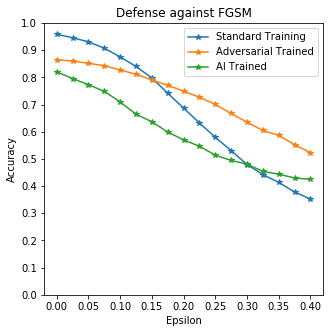

In [11]:
# Runs tests on the three models, user can define what epsilon values they would like to test. 
# Note: FGSM epsilon value is different to that of the UAA value, smaller values required.

accuracies_vani = []
examples_vani = []
accuracies_pert = []
examples_pert = []
accuracies_def = []
examples_def = []
epsilons = [0, .025, .05, .075, .1, .125, .15, .175, .2, .225, .25, .275, .3, .325, .35, .375, .4]

# Run test for each epsilon.

for eps in epsilons:
    acc_vani, ex_vani = test(model_vani, eps, test_loader = test_loader)
    accuracies_vani.append(acc_vani)
    examples_vani.append(ex_vani)
    acc_pert, ex_pert = test(model_pert, eps, test_loader = test_loader)
    accuracies_pert.append(acc_pert)
    examples_pert.append(ex_pert)
    acc_def, ex_def = test(model_def, eps, test_loader = test_loader)
    accuracies_def.append(acc_def)
    examples_def.append(ex_def)
    print("Epsilon: {}\nTest Accuracy - \t Vanila = {} \t Pertubation = {} \t AI = {}".format(eps, acc_vani, acc_pert, acc_def))

# Creates a graph of the three models accuracy against epsilon.
    
plt.figure(figsize=(5,5))
model_vani_line, = plt.plot(epsilons, accuracies_vani, "*-")
model_pert_line, = plt.plot(epsilons, accuracies_pert, "*-")
model_def_line, = plt.plot(epsilons, accuracies_def, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .425, step=0.05))
plt.title("Defense against FGSM")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend([model_vani_line, model_pert_line,model_def_line], ['Standard Training','Adversarial Trained', 'AI Trained'])
plt.savefig('..\\figures\\User_Defense_against_FGSM.png')
plt.show()

In [12]:
# These functions are used to proform tests of the Universal adversarial attack.
# Note: User needs to have ran the loss functions code from the model training section.

# Trains a pertubation to maximise its efectiveness against a given model.
# Input: The number of epochs, the model to train it on, the pertubation, training data, learning rate and max pertubation size.
# Output: A trained pertubation

def train_pert(model, pertubation, no_of_epochs = 3, train_loader = train_loader, stepsize = 0.05, epsilon = 3):

    # Trains the pertubation for the number of epochs given.
    
    for epoch in range(no_of_epochs):

        for data, target in train_loader:

            # Runs the model with the current pertubation.
            
            output = model(data + pertubation.repeat(train_loader.batch_size, 1, 1, 1))

            # Calculates the loss.
            
            loss = mse_loss_cap(output, target, 3)
            
            # Gradient decent to improve the pertubation.
            
            model.zero_grad()
            loss.backward()
            pertubation.data = pertubation.data + stepsize * pertubation.grad
            pertubation.data = pertubation.data / torch.norm(pertubation.data.view(-1, 784)) * epsilon
    
    return pertubation

# Tests the proformace of the model given a pertubation.
# Input: The model you want to test, the test data, and the pertubation.
# Output: Accuracy of the model under this pertubation.

def test_pert(model, test_loader, pertubation):

    correct = 0

    for data, target in test_loader:

        # Evaluate the model on the perturbed data.
        
        output = model(data + pertubation.repeat(test_loader.batch_size, 1, 1, 1))

        # Check for success
        
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon and return it.
    
    return correct/float(len(test_loader))

In [ ]:
# Runs tests on the three models against the universal adversarial attack, user can specify values of epsilon.
# Note: User can specify number of epochs for the pertubation to be trained on, though testing indicates no additional proformace
# above three epochs.

epsilons = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
no_of_epochs = 3

pert_epoc_acc_e = []
vani_epoc_acc_e = []
def_epoc_acc_e = []
pertubations = {}

# Run test for each epsilon

for ep in epsilons:
    pertubation_vani_e = Variable(torch.zeros(train_loader.dataset.data.size(1), \
                          train_loader.dataset.data.size(2)), requires_grad=True)
    train_pert(model_vani, pertubation_vani_e, no_of_epochs = no_of_epochs, train_loader = train_loader, epsilon = ep)
    pertubation_pert_e = Variable(torch.zeros(train_loader.dataset.data.size(1), \
                          train_loader.dataset.data.size(2)), requires_grad=True)
    train_pert(model_pert, pertubation_pert_e, no_of_epochs = no_of_epochs, train_loader = train_loader, epsilon = ep)
    pertubation_def_e = Variable(torch.zeros(train_loader.dataset.data.size(1), \
                          train_loader.dataset.data.size(2)), requires_grad=True)
    train_pert(model_def, pertubation_def_e, no_of_epochs = no_of_epochs, train_loader = train_loader, epsilon = ep)
    acc_vani = test_pert(model_vani, test_loader, pertubation_vani_e)
    vani_epoc_acc_e.append(acc_vani)
    acc_pert = test_pert(model_pert, test_loader, pertubation_pert_e)
    pert_epoc_acc_e.append(acc_pert)
    acc_def = test_pert(model_def, test_loader, pertubation_def_e)
    def_epoc_acc_e.append(acc_def)
    pertubations[ep] = [pertubation_vani_e, pertubation_pert_e, pertubation_def_e]
    print("Epsilon: {} \nTest Accuracy - \t Vanila = {} \t Pertubation = {} \t AI = {}".format(ep, acc_vani, acc_pert, acc_def))
  
# Creates figure of the accuracy of the models against the Uiversal Adverserial Attack against the epsilon values.

plt.figure(figsize=(5,5))
model_vani_line, = plt.plot(epsilons, vani_epoc_acc_e, "*-")
model_pert_line, = plt.plot(epsilons, pert_epoc_acc_e, "*-")
model_def_line, = plt.plot(epsilons, def_epoc_acc_e, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 6.5, step=1))
plt.title("Defense against Universal Adverserial Attack")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend([model_vani_line, model_pert_line, model_def_line], ['Standard Training','Adversarial Trained', 'AI Trained'])
plt.savefig('..\\Figures\\Defense_against_UAA.png')
plt.show()

Epsilon: 0.5 
Test Accuracy - 	 Vanila = 0.9698 	 Pertubation = 0.8795 	 AI = 0.7836
Epsilon: 1 
Test Accuracy - 	 Vanila = 0.9533 	 Pertubation = 0.8652 	 AI = 0.6113
Epsilon: 1.5 
Test Accuracy - 	 Vanila = 0.906 	 Pertubation = 0.8174 	 AI = 0.4377
Epsilon: 2 
Test Accuracy - 	 Vanila = 0.7886 	 Pertubation = 0.7063 	 AI = 0.2496
Epsilon: 2.5 
Test Accuracy - 	 Vanila = 0.675 	 Pertubation = 0.5934 	 AI = 0.1903


In [ ]:
# User can view a pertubation generated for a particular model and epsilon value.

ep = 2.5

# Given the model number, 0 Vanila, 1 Pertubation trained model, and 2 AI trained model.

model = 0

plt.imshow(pertubations[ep][model].data.numpy())
plt.savefig('../Figures/pertubation_vani.png')
print(torch.norm(pertubation.data.view(-1, 784)))